In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.optim.lr_scheduler as scheduler
import torch.autograd.profiler as profiler
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from MobileNetv2 import MobileNetv2
from tqdm.notebook import trange, tqdm


In [2]:
"""Load Cuda """
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
""""""""""""""""""

''

In [3]:
transform = transforms.Compose(
    [
     transforms.RandomRotation(5),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=1000,
                                          shuffle=True, num_workers=2)

valset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
valLoader = torch.utils.data.DataLoader(valset, batch_size=4,
                                         shuffle=True, num_workers=2)



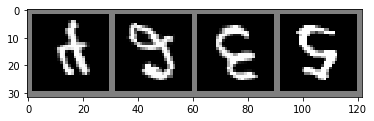

torch.Size([1000, 1, 28, 28])
tensor([4, 2, 3, 5])


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainLoader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(images.shape)
print(labels[:4])
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [5]:
if __name__ == '__main__':

    model = MobileNetv2(num_classes=10)
    model.to(device)
    summary(model, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             288
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
          Dropout-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 96, 16, 16]           1,536
      BatchNorm2d-12           [-1, 96, 16, 16]             192
            ReLU6-13           [-1, 96, 16, 16]               0
           Conv2d-14             [-1, 9

In [6]:
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.98, weight_decay=0.00004)

    epochs    = 10
    stepLr    = scheduler.StepLR(optimizer,step_size=150, gamma = 0.98)

    train_losses     = []
    train_accuracies = []   
    
    val_losses       = []
    val_accuracies = []

In [7]:
for epoch in trange(epochs, desc = "Epoch"):
    model.train()
    for step,batch in enumerate(tqdm(trainLoader, total = len(trainLoader), leave = True)):
        images,labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            preds = model(images)

            loss = criterion(preds, labels.long())

            preds = torch.argmax(preds, dim = 1)
            acc   = (preds == labels).float().mean()

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_accuracies.append(acc.item())
    tqdm.write("Epoch: {0} \tLoss: {1:.4f} \tAccuracy: {2:.4f}".format(epoch,(np.sum(train_losses)/len(train_losses)), (np.sum(train_accuracies)/len(train_accuracies))))



Epoch: 0 	Loss: 1.4626 	Accuracy: 0.4767



Epoch: 1 	Loss: 1.0263 	Accuracy: 0.6410



Epoch: 2 	Loss: 0.8026 	Accuracy: 0.7234



Epoch: 3 	Loss: 0.6684 	Accuracy: 0.7718



Epoch: 4 	Loss: 0.5780 	Accuracy: 0.8040



Epoch: 5 	Loss: 0.5121 	Accuracy: 0.8271



Epoch: 6 	Loss: 0.4627 	Accuracy: 0.8444



Epoch: 7 	Loss: 0.4240 	Accuracy: 0.8578



Epoch: 8 	Loss: 0.3922 	Accuracy: 0.8687



Epoch: 9 	Loss: 0.3657 	Accuracy: 0.8779



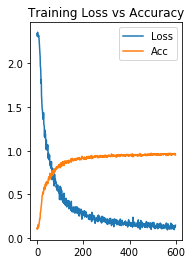

In [8]:
ax1 = plt.subplot(121)
ax1.set_title("Training Loss vs Accuracy")
ax1.plot(train_losses)
ax1.plot(train_accuracies)
ax1.legend(('Loss','Acc'))
plt.show()